# Example of usage

In this notebook, we are going to showcase a couple of practical use examples inspired by our [**article**](https://www.nature.com/articles/s41467-024-54280-4).

## Unmatched distance between graph randomizations

In the first example, we load a proximity graph and generate two families of random graphs obtained by randomizing the time index (see the function `TimeRdn` below) and by randomizing the order in which the snapshots appear (see the function `SequenceRdn` below). For each randomization, we generate $250$ graphs. We then compute a $500 \times 500$ distance matrix between all graph pairs, and we then use this matrix to cluster the graphs according to their randomization class. For simplicity, we visualize the clusters by deploying the `umap` algorithm.

<div style="background-color: #e7f3f9; border-left: 4px solid #2196F3; padding: 12px 16px; border-radius: 6px; font-family: sans-serif; color: #084b63; margin: 1em 0;">
  <span style="font-weight: bold; display: inline-flex; align-items: center;">
    <svg style="height: 16px; width: 16px; margin-right: 6px; fill: #084b63;" viewBox="0 0 16 16" xmlns="http://www.w3.org/2000/svg">
      <path d="M8 1a7 7 0 100 14A7 7 0 008 1zm.93 10.412c0 .337-.274.588-.61.588h-.64c-.336 0-.61-.251-.61-.588V7.589c0-.337.274-.589.61-.589h.64c.336 0 .61.252.61.589v3.823zM8 5.2a.867.867 0 110-1.734.867.867 0 010 1.733z"/>
    </svg>
    Note:
  </span>
 The experiment below has a relatively long computation time (~ 12 mins) because we need to generate 500 instances of random temporal graphs, beyond computing the embedding matrices.
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

# laod packages
import pandas as pd
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap

from GDynaDist import Graphs4Distance

In [2]:
# Define the functions to randomize the temporal graphs
def TimeRdn(df):
        '''With this function, time is randomized by uniformly resampling it between 0 and T, the number of snapshots'''
        df_ = copy(df)
        T = df_.t.max()
        df_.t = np.random.choice(np.arange(T), len(df_))
        return df_

def SequenceRdn(df):
    '''With this function, we randomize the order in which snapshots appear'''
    df_ = copy(df)
    t_orig = np.unique(df_.t.values)
    t_shuffled = copy(t_orig)
    np.random.shuffle(t_shuffled)
    Mapper = dict(zip(t_orig, t_shuffled))
    df_.t = df_.t.map(lambda x: Mapper[x])
    return df_

In [ ]:
# load dataset
df = pd.read_csv('Data/primaryschool.csv')

# initialize the Data class
Data = Graphs4Distance(verbose = 1)

samples = 250
names = []

# run the experiment
for i in range(samples):
    print(f'{i+1}/{samples}', end = '\r')

    df_ = TimeRdn(df) # create a randomization with the TimeRdn function
    Data.LoadDataset(df_, f'time_{i}', t_agg = 600) # load the sataset
    Data.GraphDynamicEmbedding(f'time_{i}') # create the embedding. By running this command the new dataset is immediately removed from memory, to save space
    names.append(f'time_{i}')

    df_ = SequenceRdn(df) # repeat the operation with the SequenceRdn function
    Data.LoadDataset(df_, f'sequence_{i}', t_agg = 600)
    Data.GraphDynamicEmbedding(f'sequence_{i}')
    names.append(f'sequence_{i}')

# build the distance matrix
D = np.zeros((2*samples, 2*samples))
names = np.sort(names)

for i in range(2*samples):
    for j in range(2*samples):
        D[i,j] = Data.GetDistance(names[i], names[j]) # we compute the unmatched distance between graph pairs

/home/lorenzo/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


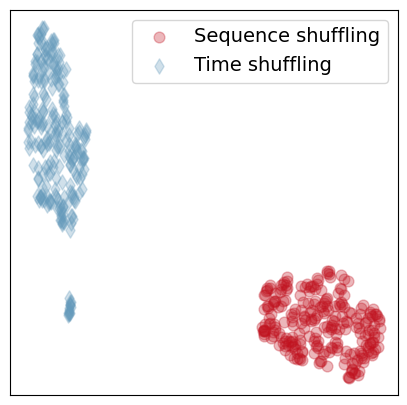

In [4]:
# get the 2D embedding from the distance matrix with umap and plot
Xembedded_umap = umap.UMAP(metric = 'precomputed').fit_transform(D)

plt.figure(figsize = (5, 5))
plt.scatter(Xembedded_umap[:,0][:samples], Xembedded_umap[:,1][:samples], marker = 'o', s = 60, color = '#c1121f', alpha = 0.3, label = 'Sequence shuffling')
plt.scatter(Xembedded_umap[:,0][samples:], Xembedded_umap[:,1][samples:], marker = 'd', s = 60, color = '#669bbc', alpha = 0.3, label = 'Time shuffling')
plt.legend(fontsize = 14)
plt.xticks([])
plt.yticks([])
plt.show();

## Recognizing a partial shuffling with the matched distance

We now test the matched distance by looking at its sensitivity to partial node relabeling. We always consider the same temporal graph and randomize the labels of a fraction $\alpha$ of its nodes. We then compute the distance between the original and reshuffled graph. The experiment is averaged over $10$ randomizations and, as we show below, the matched distance rapidly grows with $\alpha$, meaning that the matched distance between graph pairs can distinguish two graphs that only differ by the naming of their nodes. 

In [5]:
def PartialNodeShuffling(df, alpha):
    '''With this function we partially shuffle the nodes labels of the temporal graph'''

    df_ = copy(df)

    all_nodes = np.unique(df[['i', 'j']])
    n = len(all_nodes)
    idx = np.random.binomial(1, alpha, n) == 1
    all_nodes_shuffled = copy(all_nodes)
    to_be_shuffled = all_nodes_shuffled[idx]
    np.random.shuffle(to_be_shuffled)
    all_nodes_shuffled[idx] = to_be_shuffled
    NodeMapper = dict(zip(all_nodes, all_nodes_shuffled))

    df_.i = df_.i.map(lambda x: NodeMapper[x])
    df_.j = df_.j.map(lambda x: NodeMapper[x])

    return df_

In [6]:
# load dataset
df = pd.read_csv('Data/primaryschool.csv')

# initialize the Data class
Data = Graphs4Distance(verbose = 0)

Data.LoadDataset(df, 'original', t_agg = 600) # load the sataset

alphav = np.linspace(0,1,10)
n_randomization = 10

for i in range(n_randomization):
    print(f'i:{i+1}/{n_randomization}', end = '\r')
    for alpha in alphav:
        df_ = PartialNodeShuffling(df, alpha)
        Data.LoadDataset(df_, f'alpha_{alpha}_{i}', t_agg = 600) # load the sataset
        Data.GraphDynamicEmbedding(f'alpha_{alpha}_{i}') # create the embedding. By running this command the new dataset is immediately removed from memory, to save space
    

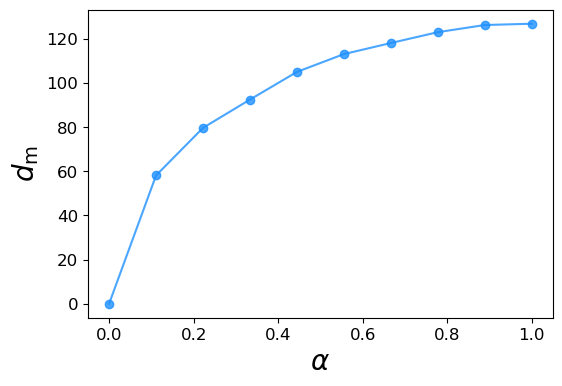

In [7]:
plt.figure(figsize = (6, 4))
plt.plot(alphav, [np.mean([Data.GetDistance('original', f'alpha_{alpha}_{i}', distance_type = 'matched', node_mapping = 'Same') for i in range(n_randomization)]) for alpha in alphav], marker = 'o', color = 'dodgerblue', alpha = 0.8)
plt.xlabel(r'$\alpha$', fontsize = 20)
plt.ylabel(r'$d_{\rm m}$', fontsize = 20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show();